# Lab 5: Species Distribution Modeling with Bagging 
Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample, shuffle

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [9]:
# Read in data
bird_traits = pd.read_csv("/courses/EDS232/Data/BirdTraitData.csv", encoding = 'unicode_escape')
bird_traits.columns



Index(['Order', 'Family', 'Genus', 'Species', 'Authority', 'CommonName',
       'AdultBodyMass', 'DietBreadth', 'Diet: invertebrates',
       'Diet: vertebrates', 'Diet: fruits', 'Diet: flower/nectar/pollen/gums',
       'Diet: seeds', 'Diet: other plant materials',
       'Diet: scavenge; garbage; carrion; offal; carcasses', 'TrophicLevel',
       'ActivityCycle', 'ForagingStratum', 'MigratoryStatus', 'IncubationTime',
       'ClutchSize', 'EggLength', 'EggWidth', 'EggMass', 'NestingHabit',
       'MaxLongevity', 'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid',
       'Alaotra.Mangoro', 'Amoron.i.Mania', 'Analamanga', 'Analanjirofo',
       'Androy', 'Anosy', 'Atsimo.Andrefana', 'Atsimo.Atsinanana',
       'Atsinanana', 'Betsiboka', 'Boeny', 'Bongolava', 'DIANA',
       'Haute.Matsiatra', 'Ihorombe', 'Itasy', 'Melaky', 'Menabe', 'SAVA',
       'Sofia', 'Vakinankaratra', 'Vatovavy.Fitovinany', 'Antananarivo',
       'Antsiranana', 'Fianarantsoa', 'Mahajanga', 'Toamasina', 'Toliara',
 

In [10]:
# Select list of 21 key variables
bird_traits.columns = [col.replace("Diet: ", "Diet_") if col.startswith("Diet: ") else col for col in bird_traits.columns]
bird_traits.columns = [col.replace("flower/nectar/pollen/gums", "flowers") if col.endswith("flower/nectar/pollen/gums") else col for col in bird_traits.columns]
bird_traits.columns = [col.replace("other plant materials", "plants") if col.endswith("other plant materials") else col for col in bird_traits.columns]
bird_traits.columns = [col.replace("scavenge; garbage; carrion; offal; carcasses", "other") if col.endswith("scavenge; garbage; carrion; offal; carcasses") else col for col in bird_traits.columns]

print(bird_traits.columns)
bird_traits = bird_traits[['AdultBodyMass', 'DietBreadth', 'Diet_invertebrates', 'Diet_vertebrates','Diet_fruits', 'Diet_flowers', 'Diet_seeds', 'Diet_plants', 'Diet_other', 'TrophicLevel','ActivityCycle', 'ForagingStratum', 'MigratoryStatus','IncubationTime', 'ClutchSize', 'EggLength', 'EggWidth','EggMass', 'NestingHabit','MaxLongevity', 'Subarid']]


bird_traits.shape


Index(['Order', 'Family', 'Genus', 'Species', 'Authority', 'CommonName',
       'AdultBodyMass', 'DietBreadth', 'Diet_invertebrates',
       'Diet_vertebrates', 'Diet_fruits', 'Diet_flowers', 'Diet_seeds',
       'Diet_plants', 'Diet_other', 'TrophicLevel', 'ActivityCycle',
       'ForagingStratum', 'MigratoryStatus', 'IncubationTime', 'ClutchSize',
       'EggLength', 'EggWidth', 'EggMass', 'NestingHabit', 'MaxLongevity',
       'Dry', 'Humid', 'Montane', 'Subarid', 'Subhumid', 'Alaotra.Mangoro',
       'Amoron.i.Mania', 'Analamanga', 'Analanjirofo', 'Androy', 'Anosy',
       'Atsimo.Andrefana', 'Atsimo.Atsinanana', 'Atsinanana', 'Betsiboka',
       'Boeny', 'Bongolava', 'DIANA', 'Haute.Matsiatra', 'Ihorombe', 'Itasy',
       'Melaky', 'Menabe', 'SAVA', 'Sofia', 'Vakinankaratra',
       'Vatovavy.Fitovinany', 'Antananarivo', 'Antsiranana', 'Fianarantsoa',
       'Mahajanga', 'Toamasina', 'Toliara', 'References'],
      dtype='object')


(242, 21)

### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [11]:
bird_traits.select_dtypes(include=['object'])

# Initialize for loop to loop through string and encode 
for col in bird_traits.select_dtypes(include=['object']):
    label_encoded = LabelEncoder()
    bird_traits[col] = label_encoded.fit_transform(bird_traits[col])
    
print(bird_traits.head())

   AdultBodyMass  DietBreadth  Diet_invertebrates  Diet_vertebrates  \
0          138.5          2.0                   2                 2   
1         1050.0          1.0                   1                 2   
2          181.0          2.0                   2                 2   
3          292.0          2.0                   2                 2   
4          511.0          2.0                   2                 2   

   Diet_fruits  Diet_flowers  Diet_seeds  Diet_plants  Diet_other  \
0            1             1           1            1           1   
1            1             1           1            1           1   
2            1             1           1            1           1   
3            1             1           1            1           1   
4            1             1           1            1           1   

   TrophicLevel  ...  ForagingStratum  MigratoryStatus  IncubationTime  \
0           3.0  ...              3.0                0            31.0   
1         

### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [12]:
# Initialize Subarid as the target
y = bird_traits['Subarid']
# Drop subarid from the df and assign to the target
X = bird_traits.drop(['Subarid'], axis = 1)

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 808)

# Initialize bagging classifier
bagging = BaggingClassifier(n_estimators=100, oob_score=True, bootstrap=True, random_state=808)

# Train model
model = bagging.fit(X_train, y_train)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [13]:
# Generate predictions
y_pred = model.predict(X_test)

# Calculate out of bag score
oob_score = model.oob_score_

# Compute model accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print oob and accuracy scores
print(f"Out of Bag Performance: {oob_score}")
print(f"Accuracy score: {accuracy}")

Out of Bag Performance: 0.8816568047337278
Accuracy score: 0.9452054794520548


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

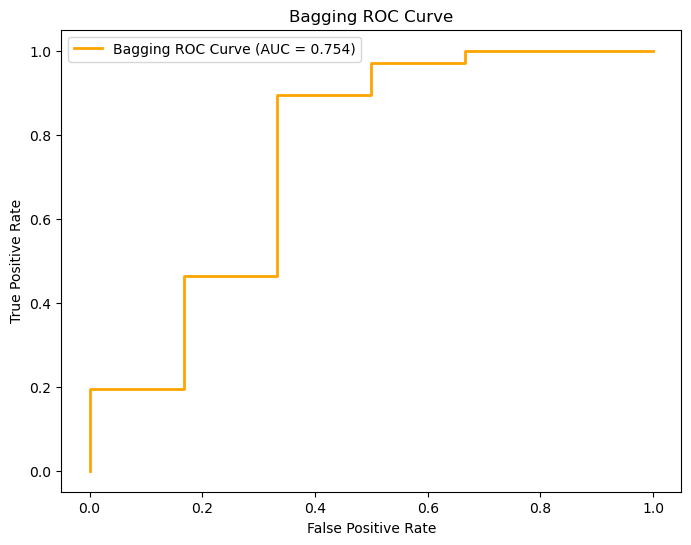

0.7537313432835822


In [14]:
# Get the probability for our ROC curve
y_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_probs)

# Compute AUC
roc_auc_bagging = auc(fpr,tpr)


# Plot curves
plt.figure(figsize=(8,6))

# Bagging ROC Curve
plt.plot(fpr, tpr, color='orange', lw=2, label=f'Bagging ROC Curve (AUC = {roc_auc_bagging:.3f})')


plt.title('Bagging ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

print(roc_auc_bagging)

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

The ROC Curve does not look like it is performing optimally, with an upward stepwise trend. The classification accuracy performance was high at a value of 0.88 for the out of bag performance and .94 for the accuracy score. The AUC is .75, comparatively. The difference in scores could be due to a class imbalance and perhaps a poor distribution of predicted scores as a result.

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [16]:
# Combine X_train and y_train into a single DataFrame for easy manipulation
df_train = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
df_majority = df_train[df_train['Subarid'] == 1]
df_minority = df_train[df_train['Subarid'] == 0]

X_train_majority = X_train[y_train == 1]
X_train_minority = X_train[y_train == 0]
y_train_majority = y_train[y_train == 1]
y_train_minority = y_train[y_train == 0]


# Upsample the minority class
X_train_upsampled_minority = resample(X_train_minority, 
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_majority),  # Match majority class count
                                 random_state=808)
y_train_upsampled_minority = resample(y_train_minority, 
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_majority),  # Match majority class count
                                 random_state=808)

# Combine majority and upsampled minority class
X_train_upsampled = pd.concat([X_train_upsampled_minority, X_train_majority])
y_train_upsampled = pd.concat([y_train_upsampled_minority, y_train_majority])

# Shuffle the dataset
X_train_upsampled = shuffle(X_train_upsampled, random_state = 808)
y_train_upsampled = shuffle(y_train_upsampled, random_state = 808)


# Print value counts 
print(X_train_upsampled.value_counts)
print(y_train_upsampled.value_counts)

<bound method DataFrame.value_counts of      AdultBodyMass  DietBreadth  Diet_invertebrates  Diet_vertebrates  \
17          2610.0          3.0                   2                 1   
51            42.5          2.0                   2                 2   
152           20.0          1.0                   2                 1   
79            79.0          1.0                   2                 1   
95           293.0          3.0                   2                 1   
..             ...          ...                 ...               ...   
110          180.0          NaN                   0                 0   
104          174.0          2.0                   2                 2   
14           685.0          2.0                   2                 1   
238         1362.0          3.0                   2                 2   
228          246.0          4.0                   1                 1   

     Diet_fruits  Diet_flowers  Diet_seeds  Diet_plants  Diet_other  \
17          

### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

Model Accuracy: 0.904


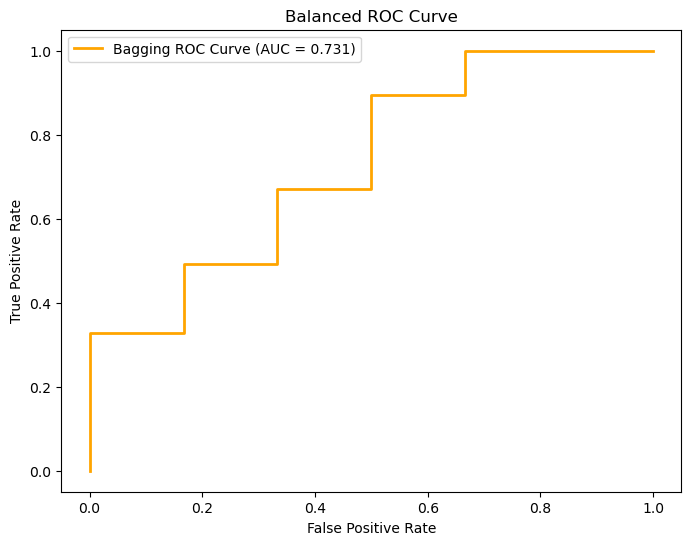

0.7313432835820896


In [19]:
# Bagging Classifier
bagging_clf = BaggingClassifier(random_state=808,
                                n_estimators=100, 
                                oob_score=True,  
                                bootstrap=True)

# Train model
bagging_clf.fit(X_train_upsampled, y_train_upsampled)

# Predict probabilities
y_pred = bagging_clf.predict(X_test)
y_prob = bagging_clf.predict_proba(X_test)[:, 1] 

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.3f}")

# ROC curve and AUC
fpr2, tpr2, _ = roc_curve(y_test, y_prob)
roc_auc_balanced = auc(fpr2, tpr2)

# Plot curves
plt.figure(figsize=(8,6))

# Bagging ROC Curve
plt.plot(fpr2, tpr2, color='orange', lw=2, label=f'Bagging ROC Curve (AUC = {roc_auc_balanced:.3f})')


plt.title('Balanced ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()


print(roc_auc_balanced)

In [20]:
print(f"Original AUC: {roc_auc_bagging:.2f}")
print(f"Balanced AUC: {roc_auc_balanced:.2f}")
print(y_test.value_counts(normalize=True))  # Look at class distribution

Original AUC: 0.75
Balanced AUC: 0.73
Subarid
1    0.917808
0    0.082192
Name: proportion, dtype: float64


How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

The second model changed slightly, with the balanced AUC being slightly lower and the accuracy score also being lower in comparison to the initial model. More specifically, the AUC of the initial model was .754 with an accuracy score of 0.94, and the balanced model had an AUC of 0.73 with an accuracy score of .904. While the balanced model may not seem to have performed as well, it is likely more realistic and less biased than the initial model. By upsampling the minority class, the model is more balanced and thus reduces the overfitting due to a class imbalance. 

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

In [21]:
# Permutation importance
perm_imp = permutation_importance(bagging_clf, # trained model
                                 X_test,
                                 y_test,
                                 n_repeats = 10,
                                 random_state=808)


# Store and view importance score
importance_score = perm_imp.importances_mean
feature_names = X_test.columns

# Create df to hold feature importances
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importance_score})

# Sort by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)

# view
importances_df

,feature,importance
18,NestingHabit,5.068493e-02
0,AdultBodyMass,2.739726e-02
15,EggLength,1.780822e-02
14,ClutchSize,1.780822e-02
3,Diet_vertebrates,5.479452e-03
1,DietBreadth,2.739726e-03
10,ActivityCycle,1.369863e-03
2,Diet_invertebrates,0.000000e+00
11,ForagingStratum,0.000000e+00
4,Diet_fruits,0.000000e+00


What features are most important in our model of species distribution?

The 3 features most important in our model of species distribution are likely nesting habit, adult body mass, and egg length because they are the greatest values of importance.